# Numerical Methods Project

### Goals:
1. Run Monte Carlo Simulation to get the distribution of returns after a given period of time for a given mean rate of return and volitility
2. Use Kelly's Critereon to find the optimum bet proportion for that distribution

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

## 1) Finding the distribution for the compound rate of return of an asset (or portfolio)

In [2]:
def stock_price_generator(s, mu, sigma, dt):
    return s + s * (mu*dt + np.random.randn()*sigma*np.sqrt(dt))

def generate_end_price(s, mu, sigma, days, length_of_year = 252): # 252 days in trading year (corresponding to mean rate of return and volitity units of per year)
    dt = 1/length_of_year # each step represents a day
    for i in range(days):
        s = stock_price_generator(s, mu, sigma, dt)
    return s

def generate_distribution(mu, sigma, days, n):
    end_prices = [generate_end_price(1, mu, sigma, days) for i in range(n)]
    return stats.gaussian_kde(end_prices)

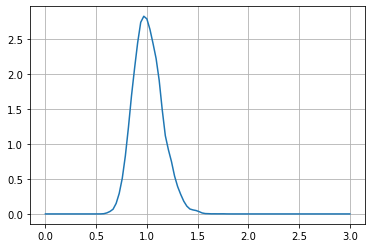

In [3]:
mean_rate_of_return = 0.08 # In % per year
volatility = 0.4 # Standard deviation in % per root year
days = 30 # To find the distribution after 1 month

distribution_of_returns = generate_distribution(mean_rate_of_return, volatility, days, 10000)

xs = np.linspace(0,3,100)
plt.plot(xs, distribution_of_returns(xs))
plt.grid()

This is the distribution of the compound rate of return on an asset (or portfolio) over a period of time. It actually can be derrived mathematically too and is called the lognormal distribution

## 2) Using Kelly's Critereon to find the optimum bet amount for the distribution

Given $G = \frac{C_n}{C_0}$, with $C_0$ the initial capital and $C_n$ the final capital after n trades,

the Kelly criterion derives the optimal fraction of capital to invest in each trade, by maximising the expectation $E[\log G]$.

In [4]:
def M(f_value, dist, M0, periods):
    M = M0
    for sample in dist.resample(periods)[0]:
        M = (1-f_value)*M + f_value*M*sample
    return M

def G(f_value, dist, M0, periods):
    M = M0
    for sample in dist.resample(periods)[0]:
        M = (1-f_value)*M + f_value*M*sample
    return M/M0

def expected_logG(f_value, dist, M0, periods, n):
    s = 0
    for i in range(n):
        s += np.log(G(f_value, dist, M0, periods))
    return s/n

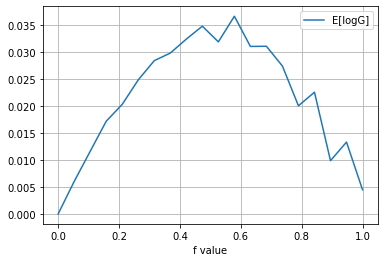

In [6]:
mean_rate_of_return = 0.08 # In % per year
volatility = 0.4 # Standard deviation in % per root year
days = 30 # To find the distribution after 1 month

distribution_of_returns = generate_distribution(mean_rate_of_return, volatility, days, 10000)

EGL = []

fs = np.linspace(0,1,20)
for f in fs:
    EGL.append(expected_logG(f, distribution_of_returns, 1000, 12, 10000))

plt.plot(fs, EGL, label = 'E[logG]')
plt.grid()
plt.xlabel('f value')
plt.legend()

From the graph, we can see that the optimal fraction of capital to invest in each trade is about 0.5. We can also calculate this analytically to be $\frac{\mu}{\sigma^2}$ which in this case is $ \frac{0.08}{0.4^2} = 0.5 $

In [53]:
def expected_M(f_value, dist, M0, periods, n):
    s = 0
    for i in range(n):
        s += M(f_value, dist, M0, periods)
    return s/n

expected_M(0.5, distribution_of_returns, 1000, 12, 10000)

1073.533645582588

Using this f value, we can expect to make about \$1070 after 12 months given an initial investment of $1000

### Question: 
Does the time of a period (e.g 30 days) and the number of periods (e.g 12 months) not effect the f value?